In [26]:
import torch
import torchvision
import torchvision.transforms as transforms
from torch import nn, optim
import matplotlib.pyplot as plt
import numpy as np

In [16]:
transform = transforms.ToTensor()

trainset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)
testset = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=transform)

100%|██████████| 9.91M/9.91M [00:00<00:00, 15.2MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 474kB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 4.42MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 5.62MB/s]


In [21]:
batch_size = 64

trainloader = torch.utils.data.DataLoader(
    trainset,
    batch_size=batch_size,
    shuffle=True
)
testloader = torch.utils.data.DataLoader(
    testset,
    batch_size=batch_size,
    shuffle=False,
)

In [18]:
from torch import nn


class Model(nn.Module):
  def __init__(self, input_dim, n_dim, class_num):
    super().__init__()

    # 첫 번째 은닉층: input_dim 차원을 n_dim 차원으로 변환
    self.layer1 = nn.Linear(input_dim, n_dim)
    # 두 번째 은닉층: n_dim 차원의 은닉층을 다시 n_dim 차원으로 변환
    self.layer2 = nn.Linear(n_dim, n_dim)
   	# 세 번째 은닉층: n_dim 차원에서 클래스 수로 출력
    self.layer3 = nn.Linear(n_dim, class_num) # 🔄 클래스 수만큼!

    self.act = nn.ReLU()

  def forward(self, x):
    x = torch.flatten(x, start_dim=1)
    x = self.act(self.layer1(x))
    x = self.act(self.layer2(x))
    x = self.layer3(x) # 출력층 (layer3 에서 activation 뺌)

    # CrossEntropyLoss에서 softmax 안 해도 됨

    return x

In [19]:
# 3. Accuracy Function
def accuracy(model, dataloader):
    model.eval() # 평가 모드 전환
    correct = 0
    total = 0

    with torch.no_grad():
        for data in dataloader:
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = model(inputs)
            preds = torch.argmax(outputs, dim=1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)

    return correct / total

In [22]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = Model(28 * 28, 1024, 10).to(device)
criterion = nn.CrossEntropyLoss()
# 모델의 파라미터 (가중치)를 학습하기 위한 Adam 최적화 알고리즘 설정
# 학습률 (learning rate) -> 0.001
# model의 가중치를 Adam 알고리즘으로 학습시킬 건데, 한 번 업데이트할 때마다 학습률은 0.001로 한다.
optimizer = optim.Adam(model.parameters(), lr=0.001)

n_epochs = 100
train_accs = []
test_accs = []

for epoch in range(n_epochs):
    model.train()
    for inputs, labels in trainloader:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

    # Accuracy 기록
    train_acc = accuracy(model, trainloader)
    test_acc = accuracy(model, testloader)
    train_accs.append(train_acc)
    test_accs.append(test_acc)

    print(f"Epoch {epoch+1}/{n_epochs} - Train Acc: {train_acc:.4f} | Test Acc: {test_acc:.4f}")

Epoch 1/100 - Train Acc: 0.9630 | Test Acc: 0.9571
Epoch 2/100 - Train Acc: 0.9867 | Test Acc: 0.9781
Epoch 3/100 - Train Acc: 0.9865 | Test Acc: 0.9776
Epoch 4/100 - Train Acc: 0.9907 | Test Acc: 0.9798
Epoch 5/100 - Train Acc: 0.9888 | Test Acc: 0.9743
Epoch 6/100 - Train Acc: 0.9912 | Test Acc: 0.9758
Epoch 7/100 - Train Acc: 0.9933 | Test Acc: 0.9803
Epoch 8/100 - Train Acc: 0.9913 | Test Acc: 0.9755
Epoch 9/100 - Train Acc: 0.9929 | Test Acc: 0.9788
Epoch 10/100 - Train Acc: 0.9975 | Test Acc: 0.9836
Epoch 11/100 - Train Acc: 0.9964 | Test Acc: 0.9817
Epoch 12/100 - Train Acc: 0.9950 | Test Acc: 0.9800
Epoch 13/100 - Train Acc: 0.9947 | Test Acc: 0.9783
Epoch 14/100 - Train Acc: 0.9961 | Test Acc: 0.9799
Epoch 15/100 - Train Acc: 0.9927 | Test Acc: 0.9791
Epoch 16/100 - Train Acc: 0.9972 | Test Acc: 0.9820
Epoch 17/100 - Train Acc: 0.9990 | Test Acc: 0.9844
Epoch 18/100 - Train Acc: 0.9980 | Test Acc: 0.9811
Epoch 19/100 - Train Acc: 0.9959 | Test Acc: 0.9799
Epoch 20/100 - Train 

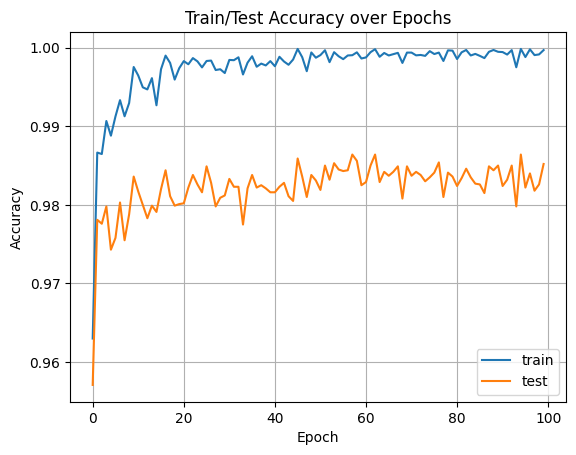

In [27]:
def plot_acc(train_accs, test_accs, label1='train', label2='test'):
    x = np.arange(len(train_accs))
    plt.plot(x, train_accs, label=label1)
    plt.plot(x, test_accs, label=label2)
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True)
    plt.title('Train/Test Accuracy over Epochs')
    plt.show()

plot_acc(train_accs, test_accs)